#### FROM MNIST TO CELEBA TO CATANDDOG

In [1]:
# both loss functions are working
# batch norm working now

# data api make it better
# change the architecture and models
# redefine the loss functions


In [4]:
import tensorflow as tf
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("../data/MNIST_data/")

In [6]:
# plt.imshow(mnist.train.images[4].reshape(28,28))

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.50)

In [8]:
from ops import *

In [19]:
tf.reset_default_graph()
# image size should be multiple of 16
image_size = 128
image_channel = 3
z_shape = 100
batch_size = 32
maxpool_stride = 2
normal_stride = 1

df_size = 5 # dsicriminator filter
df_channel = 32
gf_size = image_size //16 # generator filter
gf_channel = 40

In [20]:
def DN(X,reuse=None):
    X = tf.reshape(X,shape=[-1,image_size,image_size,image_channel])
    with tf.variable_scope('dis',reuse=reuse):
        l1 = lrelu(conv2d(X,df_size,image_channel,df_channel,maxpool_stride,'l1'))
        l2 = lrelu(conv2d(l1,df_size,df_channel,df_channel*2,maxpool_stride,'l2'))
        l3 = lrelu(conv2d(l2,df_size,df_channel*2,df_channel*4,maxpool_stride,'l3'))
        l4 = lrelu(conv2d(l3,l3.get_shape()[1],df_channel*4,1024,normal_stride,'l4','valid')) # valid padding
        l5 = conv2d(l4,1,1024,1,normal_stride,'l5','valid') # valid padding
        output = tf.reshape(l5,shape=[-1,1*1*1])
        
        return output
    
    
    
def DN_bn(X,reuse=None):
    # no batch norm to discriminator input layer
    X = tf.reshape(X,shape=[-1,image_size,image_size,image_channel])
    with tf.variable_scope('dis',reuse=reuse):
        l1 = lrelu(conv2d(X,df_size,image_channel,32,maxpool_stride,'l1'))
        l2 = lrelu(batch_norm(conv2d(l1,df_size,32,64,maxpool_stride,'l2')))
        l3 = lrelu(batch_norm(conv2d(l2,df_size,64,128,maxpool_stride,'l3')))
        l4 = lrelu(batch_norm(conv2d(l3,l3.get_shape()[1],128,1024,normal_stride,'l4','valid'))) # valid padding
        l5 = conv2d(l4,1,1024,1,normal_stride,'l5','valid') # valid padding
        output = tf.reshape(l5,shape=[-1,1*1*1])
        
        return output

In [21]:
def GN(z,reuse=None):
    z = tf.reshape(z,shape=[-1,z_shape])
    with tf.variable_scope('gen'):
        l1 = relu(linear(z,gf_size*gf_size*gf_channel,'l1'))
        l1 = tf.reshape(l1,[-1,gf_size,gf_size,gf_channel])
        l2 = relu(deconv2d(l1,gf_channel,gf_channel//2,2,'l2'))
        l3 = relu(deconv2d(l2,gf_channel//2,gf_channel//4,2,'l3'))        
        l4 = relu(deconv2d(l3,gf_channel//4,gf_channel//8,2,'l4'))  
        l5 = tanh(deconv2d(l4,gf_channel//8,image_channel,2,'l5'))
        
        return l5
    
def GN_bn(z,reuse=None):
    # no batch norm to generator output layer
    z = tf.reshape(z,shape=[-1,z_shape])
    with tf.variable_scope('gen'):
        l1 = relu(batch_norm(linear(z,gf_size*gf_size*gf_channel,'l1')))
        l1 = tf.reshape(l1,[-1,gf_size,gf_size,gf_channel])
        l2 = relu(batch_norm(deconv2d(l1,gf_channel,gf_channel//2,2,'l2')))
        l3 = relu(batch_norm(deconv2d(l2,gf_channel//2,gf_channel//4,2,'l3')))        
        l4 = relu(batch_norm(deconv2d(l3,gf_channel//4,gf_channel//8,2,'l4')))  
        l5 = tanh(deconv2d(l4,gf_channel//8,image_channel,2,'l5'))
        
        return l5

In [22]:
real_image = tf.placeholder(tf.float32,shape=[batch_size,image_size,image_size,image_channel])
z = tf.placeholder(tf.float32,shape=[batch_size,z_shape])

In [23]:
with tf.name_scope('logits'):
    fake_image = GN_bn(z)
    real_p = DN_bn(real_image)
    fake_p = DN_bn(fake_image,reuse=True)

In [24]:
with tf.name_scope('variables'):
    allvars = tf.trainable_variables()
    dvars = [var for var in allvars if 'dis' in var.name]
    gvars = [var for var in allvars if 'gen' in var.name]

In [16]:
# # gan loss
# dloss = -tf.reduce_mean( tf.log(real_p) + tf.log(1. - fake_p) )
# gloss = -tf.reduce_mean( tf.log(fake_p) )

In [17]:
# # wgan loss
# dloss = -tf.reduce_mean(real_p - fake_p)
# gloss = -tf.reduce_mean(fake_p)
# clip_d = [p.assign(tf.clip_by_value(p,-0.01,0.01)) for p in dvars]

In [25]:
# wgan-gp loss
dloss = -tf.reduce_mean(real_p-fake_p)
gloss = -tf.reduce_mean(fake_p)

alpha= tf.random_uniform(shape=[1], minval=0.,maxval=1.)
differences = fake_image - real_image 
interpolates = real_image + (alpha*differences)
gradients = tf.gradients(DN(interpolates,reuse=True), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
dloss += 10*gradient_penalty

In [27]:
# # for wgan
# doptimizer = tf.train.RMSPropOptimizer(learning_rate=0.00001).minimize(dloss,var_list=dvars)
# goptimizer = tf.train.RMSPropOptimizer(learning_rate=0.00001).minimize(gloss,var_list=gvars)

# for wgan-gp and gan
doptimizer = tf.train.AdamOptimizer(learning_rate=0.0001,beta1=0,beta2=0.9).minimize(dloss,var_list=dvars)
goptimizer = tf.train.AdamOptimizer(learning_rate=0.0001,beta1=0,beta2=0.9).minimize(gloss,var_list=gvars)

In [28]:
from data import *
next_element,total_image_count,iter_init_op = get_data('../data/cropped_catdog/',image_size,image_size,image_channel,batch_size)

Total Images found : 22317
Creating batches of 32
Done reading .. !


In [29]:
n_critic = 5
total_epoch = 100
generated_images = []
dloss_x = []
dloss_y = []
gloss_x = []
gloss_y = []

In [ ]:
# main loop
with tf.Session() as sess:
    
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    sess.run(iter_init_op)
    
    print("<---- Started training ... .! ----> \n")
    for epoch in range(total_epoch):
        
        
        count = 0
        iterations = 0
        print("\nOn epoch : {}".format(epoch))
        
        while(iterations < total_image_count//batch_size):
            
            for _ in range(n_critic):
                # get the images
                ximage = sess.run(next_element)
                ximage = convert_to_tanh(ximage)
                xsample = np.random.uniform(-1.,1.,size=(batch_size,100))
                _,l1= sess.run([doptimizer,dloss],feed_dict={real_image:ximage,z:xsample})
                count += batch_size
                iterations += 1

            for _ in range(1):
                xsample = np.random.uniform(-1.,1.,size=(batch_size,100))
                _,l2 = sess.run([goptimizer,gloss],feed_dict={z:xsample})

                
        print("after {} epoch --> losses : Descriptor : {} Generator : {}".format(epoch,l1,l2))
        cur_sample = np.random.uniform(-1.,1.,size=(batch_size,100))
        gen_sample = sess.run(fake_image,feed_dict={z:cur_sample})[0]
        dloss_x.append(epoch)
        dloss_y.append(l1)
        gloss_x.append(epoch)
        gloss_y.append(l2)
        im = convert_from_tanh(np.squeeze(gen_sample))
        save_image = cv2.imwrite('./samples/train_'+str(iterations)+'_'+str(epoch)+'.jpg',im)
        if(not save_image):
            print("Error saving image")
            
        generated_images.append(im)
        print("Total data read : {}".format(count))
        
        saver.save(sess,'saved_models/catvdog.ckpt')
        
    print("\n <----- End of Training ... ----> !!\n")

<---- Started training ... .! ----> 


On epoch : 0
after 0 epoch --> losses : Descriptor : -7.897737503051758 Generator : 1.4072091579437256
Total data read : 22400

On epoch : 1
after 1 epoch --> losses : Descriptor : -14.870401382446289 Generator : 2.0260536670684814
Total data read : 22400

On epoch : 2
after 2 epoch --> losses : Descriptor : -25.09010124206543 Generator : 2.625187873840332
Total data read : 22400

On epoch : 3
after 3 epoch --> losses : Descriptor : -33.760135650634766 Generator : 6.062599182128906
Total data read : 22400

On epoch : 4
after 4 epoch --> losses : Descriptor : -54.630836486816406 Generator : 11.967846870422363
Total data read : 22400

On epoch : 5


In [62]:
len(generated_images)

10

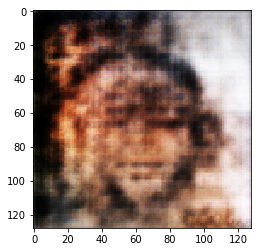

In [67]:
plt.imshow(generated_images[9])

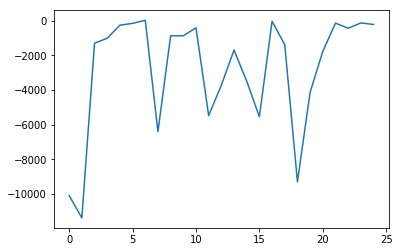

In [42]:
plt.plot(dloss_x,dloss_y)